<a href="https://colab.research.google.com/github/MrJunio/algoritmo_genetico_treinamento_rna/blob/main/Projeto_Final_de_Curso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import random as rd
import math


In [ ]:
def init_population(qtd_individuals, size_individual):
  population = []
  for i in range(0, qtd_individuals):
    individual = [np.random.normal(0,1) for i in range(size_individual)]
    population.append(individual)
  return population

In [ ]:
def get_layers(model):
    submodules = list(model.children())
    if len(submodules) == 0:
        return [model]
    else:
        res = []
        for module in submodules:
            res += get_layers(module)
        return res

def build_torch_layer_from_list(size, layer_parameter_list):
  layer_parameter_list_copy = layer_parameter_list.copy()
  qtd_neurons = size[0]
  qtd_inputs_per_neuron = size[1]
  tensor = torch.Tensor(layer_parameter_list_copy)
  tensor_resized = tensor.view(qtd_neurons, qtd_inputs_per_neuron)
  return tensor_resized

def build_torch_bias_from_list(bias_parameter_list):
  bias_parameter_list_copy = bias_parameter_list.copy()
  return torch.Tensor(bias_parameter_list_copy)

# Note that the neuralNetwork is not returned, as its reference is changed.
def fill_neural_network_from_individual(individual, neuralNetwork):
  nn_parameters = individual.copy()
  for layer in get_layers(neuralNetwork):
    qtd_inputs_per_neuron = layer.in_features
    qtd_neurons = layer.out_features
    qtd_parameters_layer = qtd_inputs_per_neuron*qtd_neurons

    layer_parameter_list = nn_parameters[0:qtd_parameters_layer]
    size = [qtd_neurons, qtd_inputs_per_neuron]
    layer.weight.data = build_torch_layer_from_list(size, layer_parameter_list)
    del(nn_parameters[0:qtd_parameters_layer])

    if layer.bias != None:
      size = layer.bias.data.size()[0]
      bias_parameter_list = nn_parameters[0:size]
      layer.bias.data = build_torch_bias_from_list(bias_parameter_list)
      del(nn_parameters[0:size])

def fitness(mini_batch, individual, neuralNetwork):
  fill_neural_network_from_individual(individual, neuralNetwork)

  qtd_match = 0
  mini_batch_copy = mini_batch.copy()
  for data in mini_batch_copy:
    input = data[0]
    expected_output = data[1]

    y = neuralNetwork(input)
    output = 0
    # If we have a single neuron at the output, round the output to the nearest
    # integer (0 or 1). This applies to binary classification problems.
    if y.size(dim=1) == 1:
      output = int(y.round().item())
    else:
      output = y.argmax().item()

    if output == expected_output.item():
      qtd_match += 1

  loss =  1 - (qtd_match/len(mini_batch_copy))
  return loss


In [ ]:
def crossover(parents):
  scrambled_parents = parents.copy()
  rd.shuffle(scrambled_parents)
  childs = []
  for idx_parent_0 in range(0, len(scrambled_parents),2):
    idx_parent_1 = idx_parent_0+1
    parent0 = scrambled_parents[idx_parent_0].copy()
    parent1 = scrambled_parents[idx_parent_1].copy()
    for j in range(len(scrambled_parents[idx_parent_0])):
      if(rd.random() < 0.5):
        parent0[j], parent1[j] = parent1[j], parent0[j]
    childs.append(parent0)
    childs.append(parent1)
  return childs

In [ ]:
def mutation(population, C:float = 0.5):
  mutant_population = population.copy()
  for i in range(len(mutant_population)):
    for j in range(len(mutant_population[i])):
      if(np.random.uniform(0,1)<=C):
        mutant_population[i][j] = np.random.normal(0,1)
  return mutant_population

In [ ]:
def select_survivors(mini_batch, population, neuralNetwork, qtd_survivors):
  def fit(individual):
    return fitness(mini_batch, individual, neuralNetwork)
  population_copy = population.copy()
  survivors = sorted(population_copy, key=fit)[0:qtd_survivors]
  return survivors

In [ ]:
def select_parents(mini_batch, population, neuralNetwork, tx_parents:float = 0.5):
  def fit(individual):
    return fitness(mini_batch, individual, neuralNetwork)
  population_copy = population.copy()
  qtd_parents = int(len(population)*tx_parents)
  if qtd_parents % 2 != 0:
        qtd_parents -= 1
  parents = sorted(population_copy, key=fit)[0:qtd_parents]
  return parents

In [ ]:
def get_best_individual_and_error(mini_batch, population, neuralNetwork):
  population_copy = population.copy()
  best_individual = population_copy[0]
  best_individual_error = fitness(mini_batch, best_individual, neuralNetwork)

  total_error = best_individual_error
  for i in range(1, len(population_copy)):
    error = fitness(mini_batch, population_copy[i], neuralNetwork)
    total_error += error
    if(error <= best_individual_error):
      best_individual = population_copy[i]
      best_individual_error = error
  average_error = total_error/len(population_copy)
  return best_individual, best_individual_error, average_error

In [ ]:
def calc_accuracy(neuralNetwork, X_test, y_test):
  y_output_all = neuralNetwork(X_test)
  qtd_matches = 0
  for i in range(len(y_output_all)):
    output = 0
    # If we have a single neuron at the output, round the output to the nearest
    # integer (0 or 1). This applies to binary classification problems.
    if len(y_output_all[i]) == 1:
      output = int(y_output_all[i].round().item())
    else:
      output = y_output_all[i].argmax().item()

    if output == y_test[i].item():
      qtd_matches+=1
  return qtd_matches/(y_output_all.size()[0])

In [ ]:
def get_mini_batch(X, y, batch_size:int = 50):
  indexes = np.arange(len(X))
  np.random.shuffle(indexes)
  mini_batch_indexes = indexes[0:batch_size]
  X_mini_batch = X[mini_batch_indexes]
  y_mini_batch = y[mini_batch_indexes]
  return X_mini_batch, y_mini_batch

In [ ]:
def genetic_neural_network(neuralNetwork, X_train, X_test, y_train, y_test, mini_batch_size:int = 50, qtd_individuals:int = 100, qtd_generations:int = 100):
  population = init_population(qtd_individuals, neuralNetwork.count_parameters())
  best_errors_per_generation = []
  average_error_per_generation = []
  # Main loop
  for i in range(qtd_generations):
    X, y = get_mini_batch(X_train, y_train, mini_batch_size)
    mini_batch = [[x.view(1,-1), y] for x,y in zip(X, y)]
    parents = select_parents(mini_batch, population, neuralNetwork)
    sons = crossover(parents)
    mutants = mutation(sons)
    population = population+mutants
    population = select_survivors(mini_batch, population, neuralNetwork, qtd_individuals)

    # Collecting data
    survivor, survivor_error, average_error = get_best_individual_and_error(mini_batch, population, neuralNetwork)
    best_errors_per_generation.append(survivor_error)
    average_error_per_generation.append(average_error)
    print('Geração:',(i+1), ' - erro:', survivor_error, " - erro médio:", average_error)

  # Fills the neural network reference with the parameters of the best individual
  fill_neural_network_from_individual(survivor, neuralNetwork)
  return survivor, survivor_error, best_errors_per_generation, average_error_per_generation


In [ ]:
# Load datasets (iris, gender_classification, raisin_dataset, fish_dataset)
uploaded = files.upload()

Saving fish_dataset.csv to fish_dataset (1).csv
Saving gender_classification.csv to gender_classification (1).csv
Saving iris.data.csv to iris.data (1).csv
Saving raisin_dataset.csv to raisin_dataset (1).csv


In [ ]:
def plot_error(qtd_generations, error_per_generation, color, title):
  plt.plot(range(qtd_generations), error_per_generation, color)
  plt.title(title)
  plt.ylabel('Erro')
  plt.xlabel('Geração')
  plt.show()

In [ ]:
def train_mlp_sgd(X_train, y_train, hidden_layers, mini_batch_size, max_iterations=100, activation_func='relu'):
  mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, solver='sgd', batch_size=mini_batch_size, activation=activation_func, max_iter=max_iterations, random_state=42)
  mlp.fit(X_train, y_train)
  return mlp

def mlp_accuracy(mlp, X_test, y_test):
  y_pred = mlp.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred, normalize=True)
  return accuracy

In [ ]:
iris_dataset = pd.read_csv('/content/iris.data.csv')
iris_dataset.columns = ["sepal length (cm)",
                   "sepal width (cm)",
                   "petal length (cm)",
                   "petal width (cm)",
                   "species"]

# Mapping species to numeric values
mappings = {
   "Iris-setosa": 0,
   "Iris-versicolor": 1,
   "Iris-virginica": 2
}
iris_dataset["species"] = iris_dataset["species"].apply(lambda x: mappings[x])

X = iris_dataset.drop("species",axis=1).values
y = iris_dataset["species"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(4, 10)
        self.layer2 = torch.nn.Linear(10, 10)
        self.layer3 = torch.nn.Linear(10, 3)

    def forward(self, x):
      x = self.layer1(x)
      x = torch.relu(x)
      x = self.layer2(x)
      x = torch.relu(x)
      x = self.layer3(x)
      return torch.softmax(x, dim=1)

    def count_parameters(self):
      num_params = 0
      for layer_params in self.parameters():
          num_layer_params = len(layer_params.view(1,-1).tolist()[0])
          num_params += num_layer_params
      return num_params

In [ ]:
hidden_layers = (10, 10)
mini_batch_size = 70
max_iterations = 100
activation_func = 'relu'

mlp = train_mlp_sgd(X_train, y_train, hidden_layers, mini_batch_size, max_iterations, activation_func)
accuracy = mlp_accuracy(mlp, X_test, y_test)
print("Acurácia MLP SGD:", accuracy)
print("Iterações:", mlp.n_iter_)
print("Função de ativação da camada de saída:", mlp.out_activation_)

Acurácia MLP SGD: 0.9
Iterações: 100
Função de ativação da camada de saída: softmax


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
neuralNetwork = NeuralNetwork()
mini_batch_size = 70
qtd_individuals = 100
qtd_generations = 100

survivor, survivor_error, best_errors_per_generation, average_error_per_generation = genetic_neural_network(neuralNetwork, X_train, X_test, y_train, y_test, mini_batch_size, qtd_individuals, qtd_generations)

Geração: 1  - erro: 0.27142857142857146  - erro médio: 0.6232857142857142
Geração: 2  - erro: 0.2571428571428571  - erro médio: 0.5969999999999998
Geração: 3  - erro: 0.30000000000000004  - erro médio: 0.6239999999999999
Geração: 4  - erro: 0.2571428571428571  - erro médio: 0.5777142857142856
Geração: 5  - erro: 0.2857142857142857  - erro médio: 0.5762857142857137
Geração: 6  - erro: 0.3285714285714286  - erro médio: 0.5874285714285725
Geração: 7  - erro: 0.30000000000000004  - erro médio: 0.5901428571428582
Geração: 8  - erro: 0.30000000000000004  - erro médio: 0.5447142857142857
Geração: 9  - erro: 0.2857142857142857  - erro médio: 0.5334285714285723
Geração: 10  - erro: 0.30000000000000004  - erro médio: 0.5238571428571432
Geração: 11  - erro: 0.24285714285714288  - erro médio: 0.49542857142857216
Geração: 12  - erro: 0.3285714285714286  - erro médio: 0.5065714285714291
Geração: 13  - erro: 0.24285714285714288  - erro médio: 0.4957142857142863
Geração: 14  - erro: 0.3142857142857143

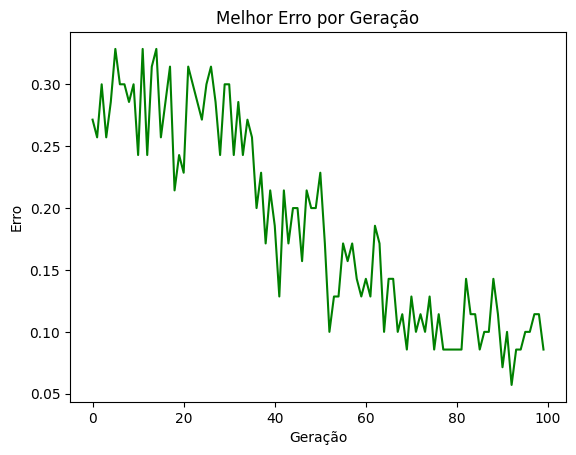

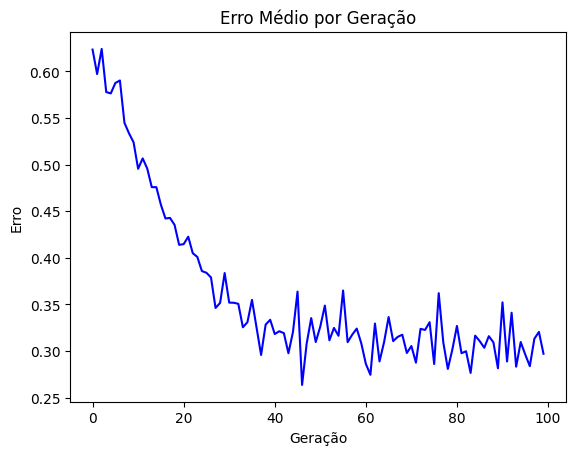

In [ ]:
plot_error(qtd_generations, best_errors_per_generation, '-g', 'Melhor Erro por Geração')
plot_error(qtd_generations, average_error_per_generation, '-b', 'Erro Médio por Geração')

In [ ]:
accuracy = calc_accuracy(neuralNetwork, X_test, y_test)
print("Acurácia:", accuracy)

Acurácia: 0.9333333333333333


In [ ]:
gender_classification = pd.read_csv('/content/gender_classification.csv')
gender_classification.columns = [
    "long_hair",
    "forehead_width_cm",
    "forehead_height_cm",
    "nose_wide",
    "nose_long",
    "lips_thin",
    "distance_nose_to_lip_long",
    "gender"
]

mappings = {
   "Male": 0,
   "Female": 1
}
gender_classification["gender"] = gender_classification["gender"].apply(lambda x: mappings[x])

X = gender_classification.drop("gender",axis=1).values
y = gender_classification["gender"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(7, 16)
        self.layer2 = torch.nn.Linear(16, 32)
        self.layer3 = torch.nn.Linear(32, 16)
        self.layer4 = torch.nn.Linear(16, 1)

    def forward(self, x):
      x = self.layer1(x)
      x = torch.relu(x)
      x = self.layer2(x)
      x = torch.relu(x)
      x = self.layer3(x)
      x = torch.relu(x)
      x = self.layer4(x)
      return torch.sigmoid(x)

    def count_parameters(self):
      num_params = 0
      for layer_params in self.parameters():
          num_layer_params = len(layer_params.view(1,-1).tolist()[0])
          num_params += num_layer_params
      return num_params

In [ ]:
hidden_layers = (16, 32, 16)
mini_batch_size = 300
max_iterations = 100
activation_func = 'relu'

mlp = train_mlp_sgd(X_train, y_train, hidden_layers, mini_batch_size, max_iterations, activation_func)
accuracy = mlp_accuracy(mlp, X_test, y_test)
print("Acurácia MLP SGD:", accuracy)
print("Iterações:", mlp.n_iter_)
print("Função de ativação da camada de saída:", mlp.out_activation_)

Acurácia MLP SGD: 0.949
Iterações: 100
Função de ativação da camada de saída: logistic


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
neuralNetwork = NeuralNetwork()
mini_batch_size = 300
qtd_individuals = 100
qtd_generations = 100

survivor, survivor_error, best_errors_per_generation, average_error_per_generation = genetic_neural_network(neuralNetwork, X_train, X_test, y_train, y_test, mini_batch_size, qtd_individuals, qtd_generations)

Geração: 1  - erro: 0.2866666666666666  - erro médio: 0.49239999999999995
Geração: 2  - erro: 0.15333333333333332  - erro médio: 0.4448666666666673
Geração: 3  - erro: 0.19666666666666666  - erro médio: 0.48973333333333285
Geração: 4  - erro: 0.17000000000000004  - erro médio: 0.4794
Geração: 5  - erro: 0.19666666666666666  - erro médio: 0.4778666666666674
Geração: 6  - erro: 0.20333333333333337  - erro médio: 0.47906666666666714
Geração: 7  - erro: 0.16333333333333333  - erro médio: 0.46486666666666676
Geração: 8  - erro: 0.13  - erro médio: 0.45360000000000045
Geração: 9  - erro: 0.12  - erro médio: 0.4386333333333333
Geração: 10  - erro: 0.14  - erro médio: 0.4566666666666667
Geração: 11  - erro: 0.08333333333333337  - erro médio: 0.4664999999999992
Geração: 12  - erro: 0.10666666666666669  - erro médio: 0.45676666666666726
Geração: 13  - erro: 0.14  - erro médio: 0.460566666666667
Geração: 14  - erro: 0.09666666666666668  - erro médio: 0.4486666666666659
Geração: 15  - erro: 0.0766

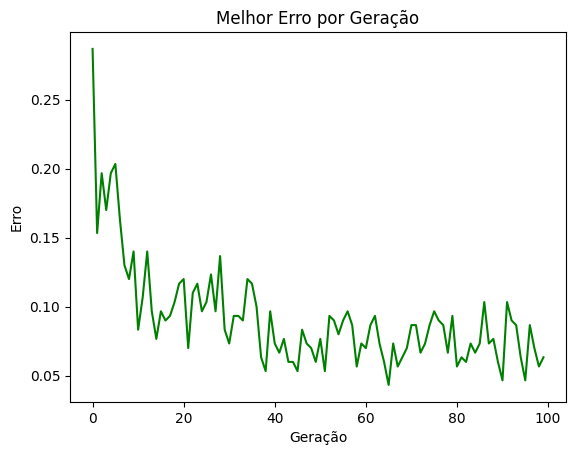

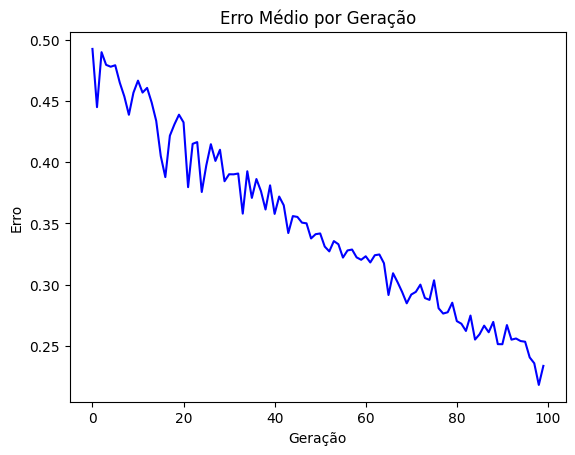

In [ ]:
plot_error(qtd_generations, best_errors_per_generation, '-g', 'Melhor Erro por Geração')
plot_error(qtd_generations, average_error_per_generation, '-b', 'Erro Médio por Geração')

In [ ]:
accuracy = calc_accuracy(neuralNetwork, X_test, y_test)
print("Acurácia:", accuracy)

Acurácia: 0.938


In [ ]:
raisin_dataset = pd.read_csv('/content/raisin_dataset.csv')
raisin_dataset.columns = [
    "area",
    "major_axis_length",
    "minor_axis_length",
    "eccentricity",
    "convex_area",
    "extent",
    "perimeter",
    "class"
]

mappings = {
   "Kecimen": 0,
   "Besni": 1
}
raisin_dataset["class"] = raisin_dataset["class"].apply(lambda x: mappings[x])

X = raisin_dataset.drop("class",axis=1).values
y = raisin_dataset["class"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(7, 8)
        self.layer2 = torch.nn.Linear(8, 8)
        self.layer3 = torch.nn.Linear(8, 8)
        self.layer4 = torch.nn.Linear(8, 1)

    def forward(self, x):
      x = self.layer1(x)
      x = torch.relu(x)
      x = self.layer2(x)
      x = torch.relu(x)
      x = self.layer3(x)
      x = torch.relu(x)
      x = self.layer4(x)
      return torch.sigmoid(x)

    def count_parameters(self):
      num_params = 0
      for layer_params in self.parameters():
          num_layer_params = len(layer_params.view(1,-1).tolist()[0])
          num_params += num_layer_params
      return num_params

In [ ]:
hidden_layers = (8, 8, 8)
mini_batch_size = 200
max_iterations = 100
activation_func = 'relu'

mlp = train_mlp_sgd(X_train, y_train, hidden_layers, mini_batch_size, max_iterations, activation_func)
accuracy = mlp_accuracy(mlp, X_test, y_test)
print("Acurácia MLP SGD: ", accuracy)
print("Iterações:", mlp.n_iter_)
print("Função de ativação da camada de saída:", mlp.out_activation_)

Acurácia MLP SGD:  0.8444444444444444
Iterações: 72
Função de ativação da camada de saída: logistic


In [ ]:
neuralNetwork = NeuralNetwork()
mini_batch_size = 200
qtd_individuals = 100
qtd_generations = 100

survivor, survivor_error, best_errors_per_generation, average_error_per_generation = genetic_neural_network(neuralNetwork, X_train, X_test, y_train, y_test, mini_batch_size, qtd_individuals, qtd_generations)

Geração: 1  - erro: 0.18999999999999995  - erro médio: 0.4041500000000005
Geração: 2  - erro: 0.17500000000000004  - erro médio: 0.4300499999999996
Geração: 3  - erro: 0.17000000000000004  - erro médio: 0.4295000000000001
Geração: 4  - erro: 0.19499999999999995  - erro médio: 0.4111999999999999
Geração: 5  - erro: 0.18500000000000005  - erro médio: 0.3443999999999993
Geração: 6  - erro: 0.15500000000000003  - erro médio: 0.32754999999999995
Geração: 7  - erro: 0.21999999999999997  - erro médio: 0.3315499999999995
Geração: 8  - erro: 0.21999999999999997  - erro médio: 0.3445500000000004
Geração: 9  - erro: 0.14  - erro médio: 0.3024500000000003
Geração: 10  - erro: 0.18999999999999995  - erro médio: 0.2864500000000002
Geração: 11  - erro: 0.16500000000000004  - erro médio: 0.27434999999999954
Geração: 12  - erro: 0.17500000000000004  - erro médio: 0.2722499999999999
Geração: 13  - erro: 0.18500000000000005  - erro médio: 0.2527500000000001
Geração: 14  - erro: 0.17000000000000004  - err

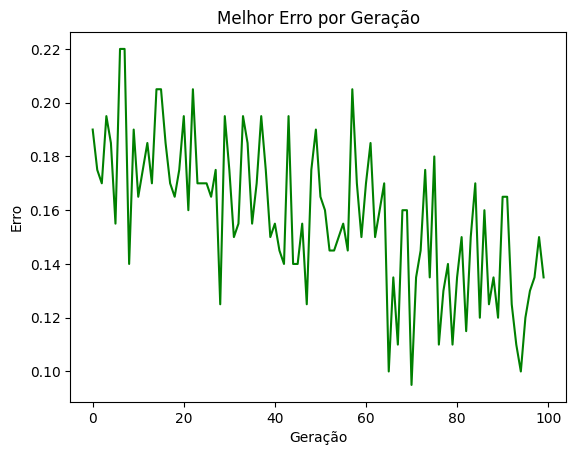

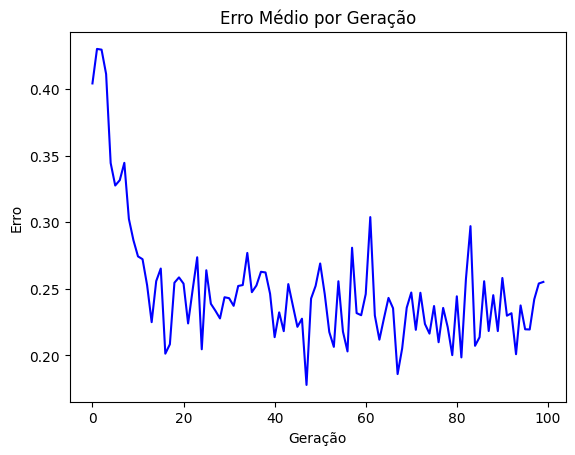

In [ ]:
plot_error(qtd_generations, best_errors_per_generation, '-g', 'Melhor Erro por Geração')
plot_error(qtd_generations, average_error_per_generation, '-b', 'Erro Médio por Geração')

In [ ]:
accuracy = calc_accuracy(neuralNetwork, X_test, y_test)
print("Acurácia:", accuracy)

Acurácia: 0.8555555555555555


In [ ]:
fish_dataset = pd.read_csv('/content/fish_dataset.csv')
fish_dataset.columns = [
    "species",
    "weight",
    "length1",
    "length2",
    "length3",
    "height",
    "width"
]

mappings = {
   "Perch":0,
   "Bream":1,
   "Roach":2,
   "Pike":3,
   "Smelt":4,
   "Parkki":5
   ,"Whitefish":6
}

fish_dataset["species"] = fish_dataset["species"].apply(lambda x: mappings[x])

X = fish_dataset.drop(["species", "length2", "length3"],axis=1).values
y = fish_dataset["species"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(4, 32)
        self.layer2 = torch.nn.Linear(32, 64)
        self.layer3 = torch.nn.Linear(64, 128)
        self.layer4 = torch.nn.Linear(128, 64)
        self.layer5 = torch.nn.Linear(64, 32)
        self.layer6 = torch.nn.Linear(32, 7)

    def forward(self, x):
      x = self.layer1(x)
      x = torch.relu(x)
      x = self.layer2(x)
      x = torch.relu(x)
      x = self.layer3(x)
      x = torch.relu(x)
      x = self.layer4(x)
      x = torch.relu(x)
      x = self.layer5(x)
      x = torch.relu(x)
      x = self.layer6(x)
      return torch.softmax(x, dim=1)

    def count_parameters(self):
      num_params = 0
      for layer_params in self.parameters():
          num_layer_params = len(layer_params.view(1,-1).tolist()[0])
          num_params += num_layer_params
      return num_params

In [ ]:
hidden_layers = (32,64,128,64,32)
mini_batch_size = 100
max_iterations = 300
activation_func='relu'

mlp = train_mlp_sgd(X_train, y_train, hidden_layers, mini_batch_size, max_iterations, activation_func)
accuracy = mlp_accuracy(mlp, X_test, y_test)
print("Acurácia MLP SGD: ", accuracy)
print("Iterações:", mlp.n_iter_)
print("Função de ativação da camada de saída:", mlp.out_activation_)

Acurácia MLP SGD:  0.65625
Iterações: 144
Função de ativação da camada de saída: softmax


In [ ]:
neuralNetwork = NeuralNetwork()
mini_batch_size = 100
qtd_individuals = 100
qtd_generations = 300

survivor, survivor_error, best_errors_per_generation, average_error_per_generation = genetic_neural_network(neuralNetwork, X_train, X_test, y_train, y_test, mini_batch_size, qtd_individuals, qtd_generations)

Geração: 1  - erro: 0.6599999999999999  - erro médio: 0.8109999999999993
Geração: 2  - erro: 0.65  - erro médio: 0.7695000000000004
Geração: 3  - erro: 0.61  - erro médio: 0.7357000000000008
Geração: 4  - erro: 0.65  - erro médio: 0.7364000000000008
Geração: 5  - erro: 0.6  - erro médio: 0.6978000000000002
Geração: 6  - erro: 0.61  - erro médio: 0.6991999999999996
Geração: 7  - erro: 0.56  - erro médio: 0.6491000000000001
Geração: 8  - erro: 0.5900000000000001  - erro médio: 0.6569999999999991
Geração: 9  - erro: 0.5900000000000001  - erro médio: 0.6602999999999993
Geração: 10  - erro: 0.5900000000000001  - erro médio: 0.6492999999999988
Geração: 11  - erro: 0.5800000000000001  - erro médio: 0.6493999999999989
Geração: 12  - erro: 0.5900000000000001  - erro médio: 0.629300000000001
Geração: 13  - erro: 0.6  - erro médio: 0.6282000000000011
Geração: 14  - erro: 0.5700000000000001  - erro médio: 0.6377000000000005
Geração: 15  - erro: 0.6  - erro médio: 0.6577999999999983
Geração: 16  - 

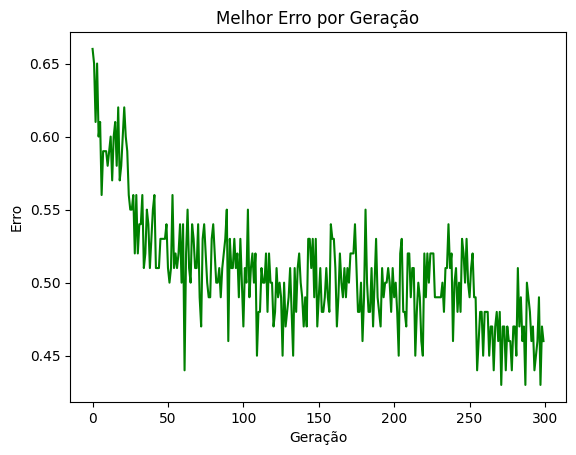

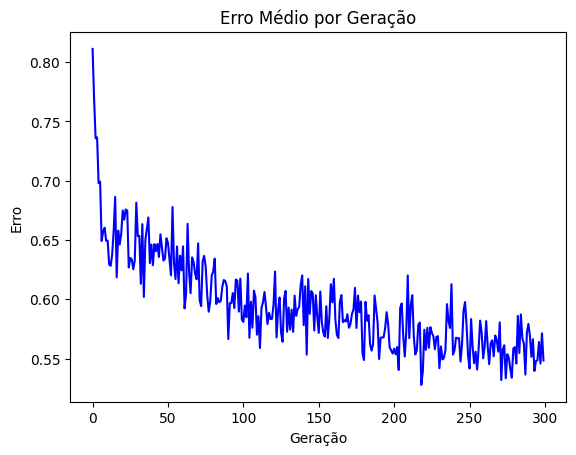

In [ ]:
plot_error(qtd_generations, best_errors_per_generation, '-g', 'Melhor Erro por Geração')
plot_error(qtd_generations, average_error_per_generation, '-b', 'Erro Médio por Geração')

In [ ]:
accuracy = calc_accuracy(neuralNetwork, X_test, y_test)
print("Acurácia:", accuracy)

Acurácia: 0.59375


In [ ]:
##############################################################################################################################################################